# PDE Labs: a basic example

This notebook is a simple example of how the standard **PDE Labs** environment can provide an interactive finite element analysis.
The goal of this notebook is to demonstrate a convergence analysis for $C^0$ linear finite element space with respect to mesh refinement.

The problem being investigated is a standard heat equation with Dirichlet boundary conditions in two dimensions:
\begin{equation}
    \Delta u(x_0, x_1) = f(x_0, x_1), \quad 0 \le x_0, x_1 \le 1,
\end{equation}
where the source term, $f$, is chosen to yield a known solution so that the error of the computed solution can be compared to the interpolant of the exact solution.

Below are imports and some utility functions that simplify the presented analysis that follows.

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np

from typing import List
from dolfin import (
    DirichletBC,
    Expression,
    Function,
    FunctionSpace,
    LUSolver,
    Mesh,
    TestFunction,
    TrialFunction,
    UnitSquareMesh,
    assemble,
    dx,
    errornorm,
    grad,
    inner,
    interpolate,
)

"""
    Thanks to Chris Richardson for providing the basis for the following
    plotting functions:
        https://fenicsproject.org/qa/5795/plotting-dolfin-solutions-in-matplotlib/
"""

def mesh_to_triangulation(mesh: Mesh) -> tri.Triangulation:
    if (mesh.geometry().dim() != 2):
            raise(AttributeError)

    xy = mesh.coordinates()
    return tri.Triangulation(xy[:, 0], xy[:, 1], mesh.cells())


def plot_mesh(ax, mesh: Mesh):
    ax.set_aspect('equal')
    ax.set_xlabel('mesh')
    ax.triplot(mesh_to_triangulation(mesh), color='k')


def plot_solution(ax, mesh: Mesh, solution: Function):
    ax.set_aspect('equal')
    ax.set_xlabel('computed solution')
    triang: tri.Triangulation = mesh_to_triangulation(mesh)

    if solution.vector().size() == mesh.num_cells():
        solution_array = solution.vector().array()
        ax.tripcolor(triang, solution_array, vmin=0., vmax=1.)

    else:
        solution_array = solution.compute_vertex_values(mesh)
        ax.tripcolor(triang, solution_array, vmin=0., vmax=1., shading='gouraud')
        
        
def plot_error(ax, mesh: Mesh, exact: Function, computed: Function):
    ax.set_aspect('equal')
    ax.set_xlabel('error')
    triang: tri.Triangulation = mesh_to_triangulation(mesh)

    if exact.vector().size() == mesh.num_cells():
        exact_array = exact.vector().array()
        computed_array = computed.vector().array()
        return ax.tripcolor(triang, exact_array - computed_array, cmap='RdBu_r')

    else:
        exact_array = exact.compute_vertex_values(mesh)
        computed_array = computed.compute_vertex_values(mesh)
        return ax.tripcolor(triang, exact_array - computed_array, shading='gouraud', cmap='RdBu_r')

# The differential equation

The exact solution is defined by
\begin{equation}
  u(x_0, x_1) = \sin(2\pi x_0) \cos(2\pi x_1), \quad \mathrm{for}\ 0 \le x_0, x_1 \le 1.
\end{equation}

The corresponding source term is then
\begin{equation}
  f(x_0, x_1) = \Delta u(x_0, x_1) = 8\pi^2\sin(2\pi x_0) \cos(2\pi x_1).
\end{equation}

These functions are prescribed below using the `dolfin.Expression` class.
A polynomial degree of 4 is used so that the interpolation error does not dominate the error investigated in this analysis.

In [15]:
# exact_solution = Expression("sin(DOLFIN_PI * x[0]) * sin(DOLFIN_PI * x[1])", degree=4)
# source = Expression(
#     "2. * DOLFIN_PI * DOLFIN_PI * sin(DOLFIN_PI * x[0]) * sin(DOLFIN_PI * x[1])",
#     degree=4,
# )

exact_solution = Expression(
    "pow(sin(2. * DOLFIN_PI * x[0]) * sin(2. * DOLFIN_PI * x[1]), 2.)",
    degree=4,
)

source = Expression(
    """
    -8. * DOLFIN_PI * DOLFIN_PI * ( \
        cos(4. * DOLFIN_PI * x[0]) * pow(sin(2. * DOLFIN_PI * x[1]), 2.) \
        + cos(4. * DOLFIN_PI * x[1]) * pow(sin(2. * DOLFIN_PI * x[0]), 2.) \
    )
    """,
    degree=4,
)

# Discretization

As mentioned above, the finite element space is $C^0$ linear finite elements on the unit mesh, denoted by $\mathcal{V}_h$.
Again, `dolfin` provides the convenient `UnitSquareMesh`,
as well as `FunctionSpace`, `TrialFunction`, and `TestFunction` classes for easily defining the discretization,
as seen below.
A method is defined for returning the corresponding discretizations for a given `granularity` that determines the mesh size.

In [16]:
def boundary(x, on_boundary):
    """
    helps dolfin define boundary terms
    """
    return on_boundary
    

def discretize(granularity: int) -> (UnitSquareMesh, FunctionSpace, TrialFunction, TestFunction):
    mesh = UnitSquareMesh(granularity, granularity)
    fe_space = FunctionSpace(mesh, "Lagrange", 1)
    trial_fn = TrialFunction(fe_space)
    test_fn = TestFunction(fe_space)
    
    return mesh, fe_space, trial_fn, test_fn


# The finite element formulation

The finite element formulation solves the weak form of the differential equation
by finding the unique solution in the finite dimensional subspace, $\mathcal{V}_h$, of $\mathcal{H}^1$:
\begin{equation}
    (\nabla u_h, v_h) + (f, v_h) = 0, \qquad\mathrm{for\ all}\ v_h \in \mathcal{V}_h,
\end{equation}
where $u_h(x_0, x_1) = u(x_0, x_1) = \sin(2\pi x_0)\cos(2\pi x_1)$ is the Dirichlet boundary condition.

To write the finite element formulation,
`dolfin` uses a *Unified Form Language* (UFL) compiler to easily describe the problem in a familiar form.
The compiled forms are assembled into a linear system of equations that are solved by a non-symmetric LU solver in the function below.

Since this analysis is concerned with verifying the theoretical rate of convergence for the finite element formulation,
the `compute_solution` function takes in a single parameter that describes the mesh granularity.
This makes it straightforward to compute solutions on uniformly refining meshes.

In [17]:
def compute_solution(granularity: int) -> Function:
    mesh, fe_space, trial_fn, test_fn = discretize(granularity)
    
    # UFL discretization expression
    bc = DirichletBC(fe_space, exact_solution, boundary)
    bilinear_form = inner(grad(trial_fn), grad(test_fn)) * dx
    linear_form = source * test_fn * dx
    solution = Function(fe_space)

    # assembly
    stiffness_matrix = assemble(bilinear_form)
    rhs_vector = assemble(linear_form)
    bc.apply(stiffness_matrix, rhs_vector)

    # linear solver
    solver = LUSolver(stiffness_matrix, "default")
    solver.parameters["symmetric"] = False
    solver.solve(solution.vector(), rhs_vector)
    
    return solution

# Convergence data

In considering the convergence of the finite element solution with respect to increasing granularity of the mesh,
the following convenience class has been defined that is instantiated with a single parameter, the mesh granularity.
With this, this class computes the solution on the corresponding mesh as well as the error in the $\mathcal{H}^1$ sense.
There is also a convenient plotting method for visualizing the mesh, computed solution, and localized error.

In [18]:
class ConvergenceDatum(object):
    def __init__(self, granularity):
        self.granularity = granularity
        self.computed_solution = compute_solution(granularity)
        self.error = errornorm(exact_solution, self.computed_solution, "H1", 3)

        self._mesh = self.computed_solution.function_space().mesh()
        self._interpolant = interpolate(exact_solution, self.computed_solution.function_space())

    def plot(self):
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(17, 5))
        axs = axs.flatten()
        plot_mesh(axs[0], self._mesh)
        plot_solution(axs[1], self._mesh, self.computed_solution)
        tcp = plot_error(axs[2], self._mesh, self._interpolant, self.computed_solution)

        fig.colorbar(tcp)
        fig.suptitle(f"At granularity {self.granularity}, the H1-error is {self.error:e}.", fontsize=14)
        plt.show()


# Numerical results
Using the convergence data class above, finite element solutions are computed on a sequence of uniformly refined meshes with meshes, computed solutions, and errors plotted for visual inspection. 

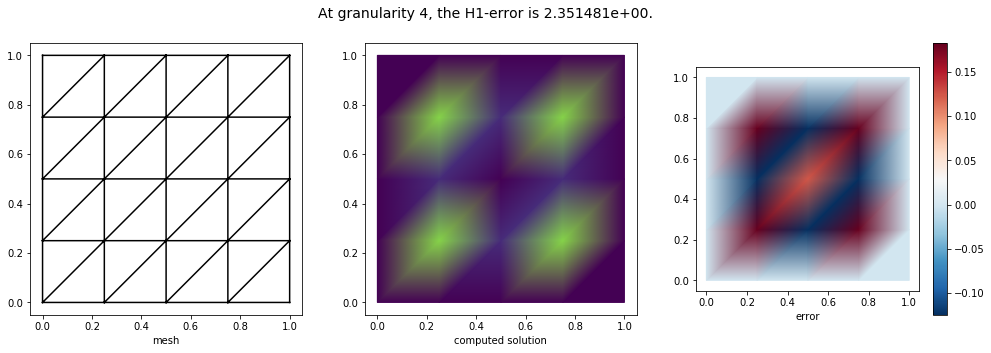

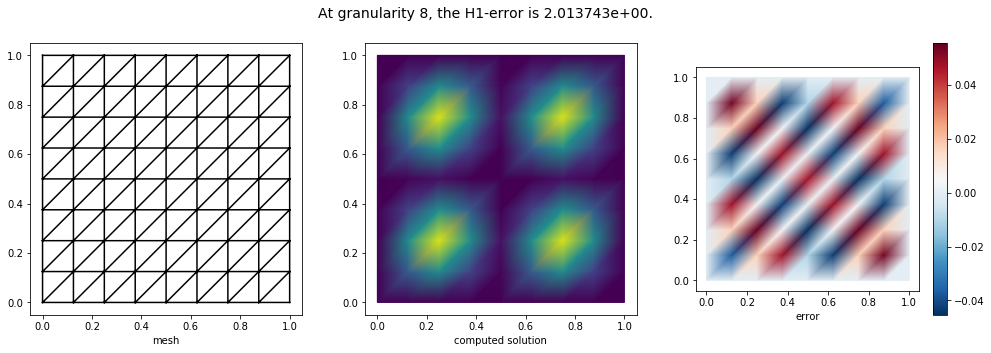

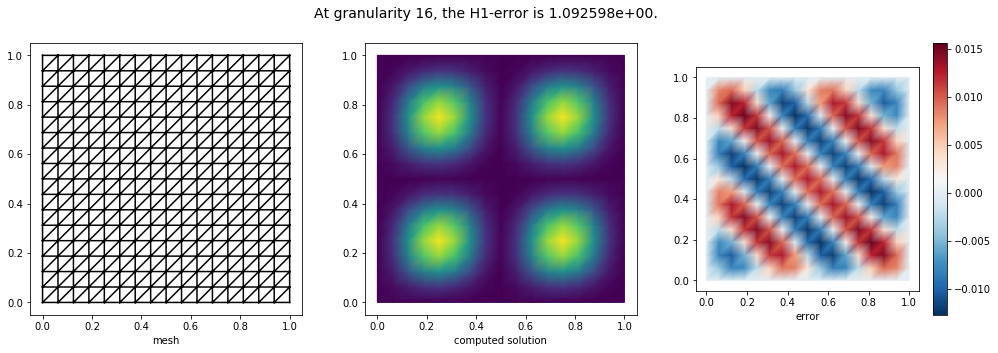

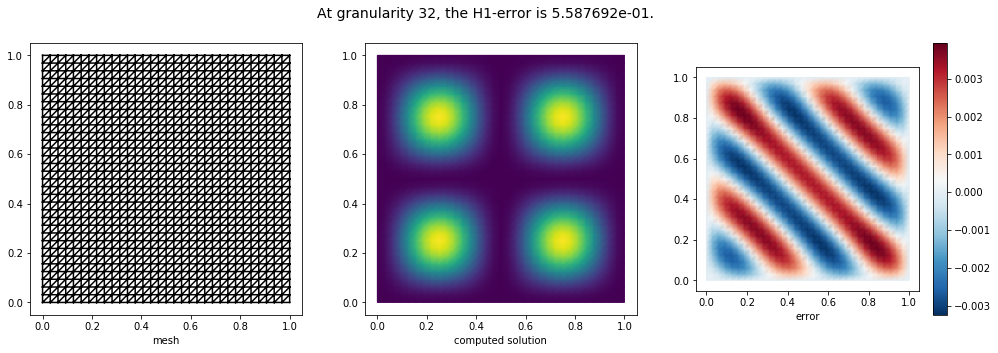

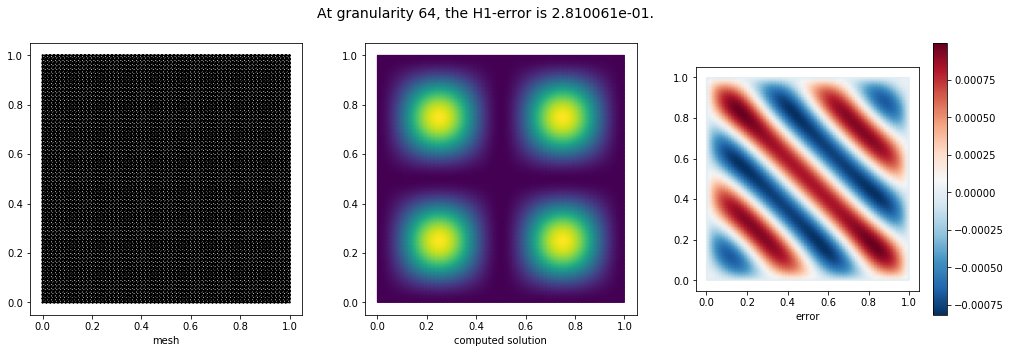

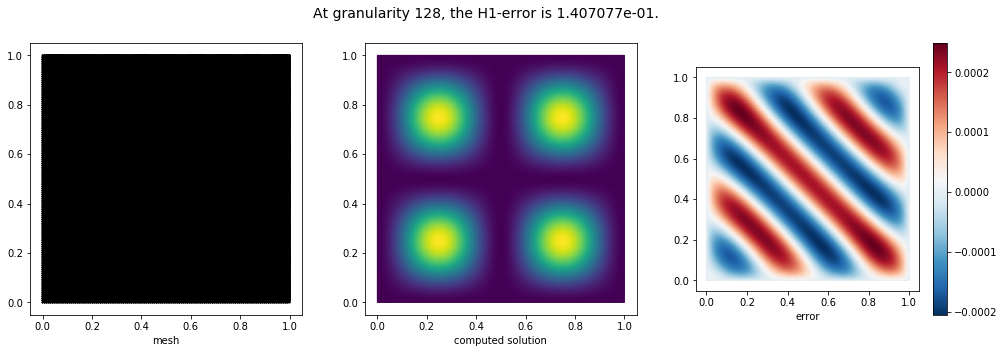

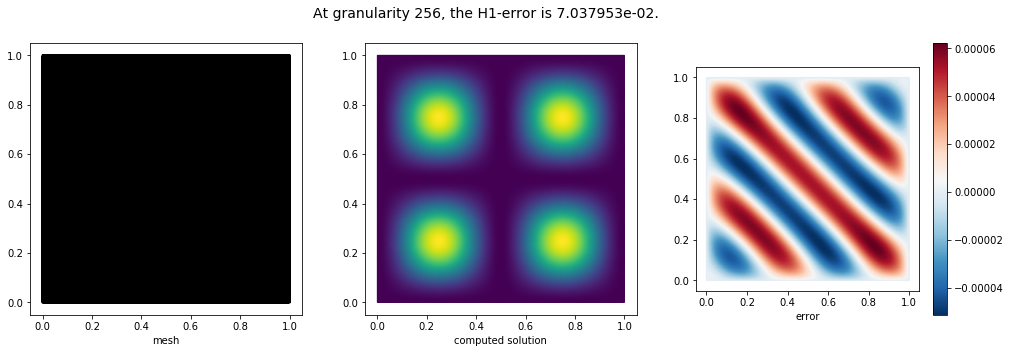

In [19]:
granularities = [4, 8, 16, 32, 64, 128, 256]
convergence_data = [ConvergenceDatum(granularity) for granularity in granularities]

for datum in convergence_data:
    datum.plot()

# Verification of convergence rate
First order (linear) finite element spaces are theoretically expected to converge in the $\mathcal{H}^1$ sense
at a rate proportional to the size of the elements in the mesh.
Mathematically, this is expressed by:
\begin{equation}
    \| u-u_h \|_1 \le C h.
\end{equation}

(On a technical note, the computed solution is compared to the interpolant of the exact solution;
 however, a triangle inequality and the boundedness of the second derivative of the exact solution establishes the desired bound:
\begin{equation}
    \| u-u_h \|_1 \le \| u-\mathcal{I}_h(u) \|_1 + \| \mathcal{I}_h(u) - u_h \|_1 \le  C'h,
\end{equation}
where $\| u-\mathcal{I}_h(u) \|_1 \le C''|u|_2h$ and $\mathcal{I}_h$ is understood to be the interpolation operator.)

In [7]:
def plot_convergence_summary(data: List[ConvergenceDatum], expected_order: int = 1):
    log_g: np.array = np.log(np.array([d.granularity for d in data]))
    log_error: np.array = np.log(np.array([d.error for d in data]))
    ref_line: np.array = log_error[-1] + float(expected_order) * (log_g[-1] - log_g)

    plt.plot(log_g, ref_line, 'c--', label='$\mathcal{O}(h^' + f'{expected_order}' + ')$')
    plt.plot(log_g, log_error, 'k', label='$\log(\mathcal{H}^1-\mathrm{error})$')

    plt.title('Convergence plot')
    plt.xlabel('$\log(g)$')
    plt.legend()
    plt.show()

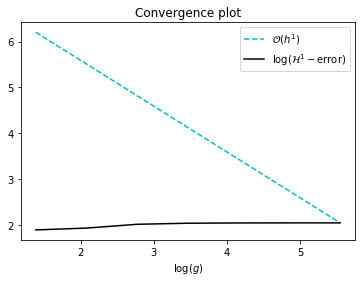

In [8]:
plot_convergence_summary(convergence_data, expected_order=1)

# Summary

As seen in the above presentation, the order of convergence is verified as expected.
Moreover, the authors hope to provide a clear example of how Jupyter notebooks,
which are ubiquitous for sharing data science and machine learning research,
can also serve the finite element and scientific computing community more generally.

Since notebooks are interactive,
it is the hope that readers modify this notebook to explore other aspects of this basic problem.

Future work includes streamlining this simple interactive environment to make it more accessible and extensible,
including examples of importing libraries for stabilizing convection-dominatied problems,
and solving nonlinear differential equations as well.